In [17]:
import requests
import pandas as pd
from datetime import datetime as dt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
BASE_URL_pre = 'https://opendata.reseaux-energies.fr/api/v2/catalog/datasets/'
BASE_URL_port = '/exports/json?rows=-1&pretty=false&timezone=UTC'
real_time_elec = 'eco2mix-national-tr'
temperature = 'temperature-quotidienne-regionale'

# Loading data
response_elec = requests.get(BASE_URL_pre + real_time_elec + BASE_URL_port)
response_temeprature = requests.get(BASE_URL_pre + temperature + BASE_URL_port)

In [30]:
df = pd.DataFrame(response_elec.json())
df[df['date_heure'] == '2020-04-30T22:00:00+00:00'][['date_heure', 'date']]

,date_heure,date
0,2020-04-30T22:00:00+00:00,2020-05-01


In [19]:
df = pd.DataFrame(response_elec.json())

# Recast date time to datetime type
df['date_heure'] = pd.to_datetime(df['date_heure'])
df.index = df['date_heure']
df['week_day'] = df['date_heure'].apply(lambda x: x.strftime('%A'))
df['week_number'] = df['date_heure'].apply(lambda x: x.strftime('%W'))
df['minutes'] = df['date_heure'].apply(lambda x: x.strftime('%M'))

# Sort data by datetime
df = df.sort_index()

# Remove useless columns and lines full of NA (futur lines)
col_to_drop = ['ech_comm_angleterre', 'ech_comm_espagne',
               'ech_comm_italie', 'ech_comm_suisse', 'ech_comm_allemagne_belgique',
              'perimetre', 'nature', 'date', 'heure', 'column_79']

df = df.drop(col_to_drop, axis=1)
df = df.dropna()

# Reorder the columns to have the new datetime columns in first
col_reindex =  np.array(df.columns)
col_reindex = np.concatenate((col_reindex[-5:], col_reindex[:-5]), axis=0)

df = df.reindex(columns=col_reindex)

# Transform to hourly dataframe
df_light = df[df['minutes'] == '00']
df_light = df_light.drop(['minutes'], axis=1)

# Add an hourly frequency to the index and forward filling if some hours are missing
df_light = df_light.asfreq('H', method='ffill')

# Remove all columns except time and conumption columns
df_light = df_light[['date_heure', 'consommation', 'week_day', 'week_number']]

# Remove values for the current day
df_light = df_light[~df_light['date_heure'].astype(str).str.contains(dt.now().strftime('%Y-%m-%d'))]

# Type of day
# Weekday : 1
# Saturday : 0
# Free days and Sunday : -1
df_light['type_of_day'] = df_light['week_day']\
    .apply(lambda x: -1 if x == 'Sunday' else(0 if x == 'Saturday' else 1)) 

def free_day(df, date):
    df['type_of_day'][df['date_heure'].astype(str).str.contains(date)] = -1
    return df

free_day(df_light, '2020-05-01')
free_day(df_light, '2020-05-08')
free_day(df_light, '2020-05-10')
free_day(df_light, '2020-05-21')

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date_heure,consommation,week_day,week_number,type_of_day
date_heure,,,,,
2020-04-30 22:00:00+00:00,2020-04-30 22:00:00+00:00,45533.0,Thursday,17,1
2020-04-30 23:00:00+00:00,2020-04-30 23:00:00+00:00,41155.0,Thursday,17,1
2020-05-01 00:00:00+00:00,2020-05-01 00:00:00+00:00,39923.0,Friday,17,-1
2020-05-01 01:00:00+00:00,2020-05-01 01:00:00+00:00,37018.0,Friday,17,-1
2020-05-01 02:00:00+00:00,2020-05-01 02:00:00+00:00,35217.0,Friday,17,-1
...,...,...,...,...,...
2020-06-18 19:00:00+00:00,2020-06-18 18:00:00+00:00,45493.0,Thursday,24,1
2020-06-18 20:00:00+00:00,2020-06-18 18:00:00+00:00,45493.0,Thursday,24,1
2020-06-18 21:00:00+00:00,2020-06-18 18:00:00+00:00,45493.0,Thursday,24,1


In [20]:
%%time
# SARIMAX Prediction
train_days = df_light['consommation'] / df_light['consommation'].mean()

exog_train = df_light['type_of_day']

model = SARIMAX(train_days, order=(10, 1, 1), seasonal_order=(0, 0, 0, 0), exog=exog_train)

model_fit = model.fit(disp=False)

/home/ranto/.pyenv/versions/3.7.6/envs/vivadata/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 56.6 s, sys: 52.4 s, total: 1min 49s
Wall time: 14.6 s


In [24]:
n_pred = 72

start = exog_train.index[-1]
end = exog_train.index[-1] + pd.Timedelta(f'{n_pred}h')

index = pd.date_range(start=start, periods=n_pred, freq='H', name='date_heure')
exog_test = pd.DataFrame(np.ones((n_pred), int), index=index, columns=['type_of_day'])
exog_test['week_day'] = exog_test.index
exog_test['type_of_day'] = exog_test['week_day']\
    .apply(lambda x: -1 if x.strftime('%A') == 'Sunday' else (0 if x.strftime('%A') == 'Saturday' else 1))
exog_test = pd.Series(exog_test['type_of_day'])

In [25]:
prediction = model_fit.get_prediction(start=start, end=end, exog=exog_test)
pred = prediction.predicted_mean

In [27]:
pred * df_light['consommation'].mean()

2020-06-18 23:00:00+00:00    42951.873038
2020-06-19 00:00:00+00:00    37182.527760
2020-06-19 01:00:00+00:00    36860.383874
2020-06-19 02:00:00+00:00    36316.044169
2020-06-19 03:00:00+00:00    36307.458559
                                 ...     
2020-06-21 19:00:00+00:00    39362.769653
2020-06-21 20:00:00+00:00    39376.548508
2020-06-21 21:00:00+00:00    39399.107080
2020-06-21 22:00:00+00:00    39425.326253
2020-06-21 23:00:00+00:00    39449.319280
Freq: H, Length: 73, dtype: float64

In [28]:
import matplotlib.pyplot as plt

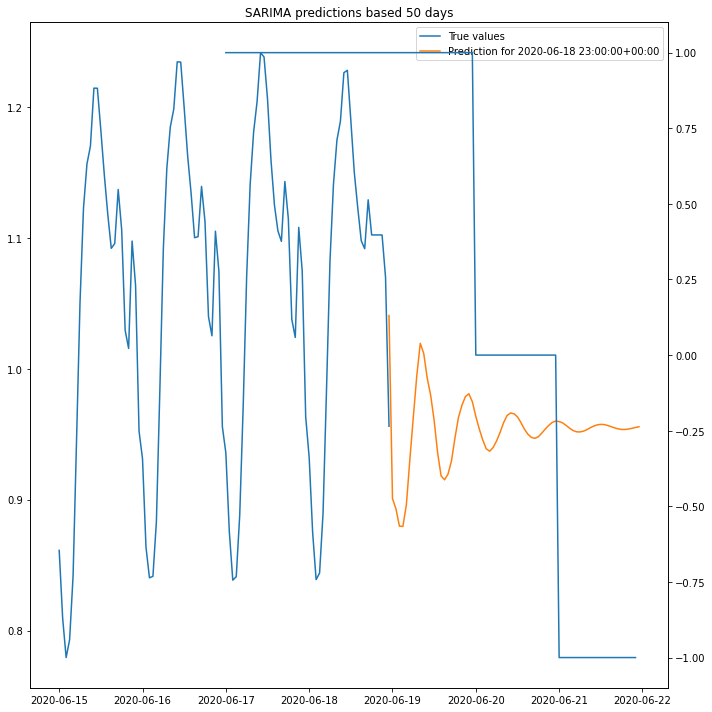

In [29]:
fig, ax1 = plt.subplots(figsize=(10, 10))

ax2 = ax1.twinx()

ax1.plot(train_days.iloc[-96:], label='True values')

ax2.plot(pd.concat((exog_train, exog_test), axis=0).iloc[-120:], label='Type of day')

ax1.plot(pred, label=f'Prediction for {start}')

plt.title("SARIMA predictions based 50 days")
ax1.legend()

fig.tight_layout()

plt.show()

### Visualization

In [8]:
!ls ../app

app.py	data		    make_predictions.py  Procfile     requirements.txt
assets	generate_graphs.py  prediction-models	 __pycache__


In [9]:
import sys
sys.path.append('../app')
from make_predictions import *

In [10]:
import plotly.graph_objects as go
import pickle
from plotly.subplots import make_subplots

In [11]:
font_color = '#cdc6c6'
paper_bgcolor = '#141414'
plot_bgcolor = '#383838'

In [52]:
# def make_predictions(n_pred: int):
n_pred = 48

daily_model_path = '../app/prediction-models/daily_model.pkl'
hourly_model_path = '../app/prediction-models/hourly_model.pkl'
daily_consumption_path = '../app/data/daily_consumption.pkl'
exog_train_path = '../app/data/exog_train.pkl'
df_light_path = '../app/data/df_light.pkl'

with open(daily_consumption_path, 'rb') as f:
    daily_consumption = pickle.load(f)

with open(exog_train_path, 'rb') as f:
    exog_train = pickle.load(f)

with open(df_light_path, 'rb') as f:
    df_light = pickle.load(f)

with open(daily_model_path, 'rb') as f:
    daily_model = pickle.load(f)

n_pred_day = math.ceil(n_pred / 24)
start_day = start_test_day_stamp(daily_consumption)
end_day = end_test_day_stamp(daily_consumption, n_pred_day)
exog_test_for_daily_pred = exogenous_daily_test_data(exog_train, n_pred_day)

# Daily prediction multiplied by mean past consumption
daily_predictions = daily_model.get_prediction(start=start_day,
                                            end=end_day,
                                            exog=exog_test_for_daily_pred).predicted_mean * df_light['consommation'].mean()

# Confidence interval of the daily prediction
conf_int_pred_daily = daily_model.get_prediction(start=start_day,
                                            end=end_day,
                                            exog=exog_test_for_daily_pred).conf_int() * df_light['consommation'].mean()

with open(hourly_model_path, 'rb') as f:
    hourly_model = pickle.load(f)

start_hour = start_test_hour_stamp(exog_train)
end_hour = end_test_hour_stamp(exog_train, n_pred)
exog_test_for_hourly_pred = exogenous_hourly_test_data(exog_train, n_pred)

# Hourly prediction which will be multiplied by daily prediction
hourly_predictions = hourly_model.get_prediction(start=start_hour,
                                            end=end_hour,
                                            exog=exog_test_for_hourly_pred).predicted_mean

# Confidence interval of the hourly prediction
conf_int = hourly_model.get_prediction(start=start_hour,
                                            end=end_hour,
                                            exog=exog_test_for_hourly_pred).conf_int()

# Daily prediction dataframe transformed to hourly frequence dataframe
pred_hourly_with_mean_values = convert_hourly_to_daily(hourly_predictions, daily_predictions)

conf_int_pred_hourly_with_mean_values_lower = convert_hourly_to_daily(hourly_predictions, conf_int_pred_daily.iloc[:,0])
conf_int_pred_hourly_with_mean_values_upper = convert_hourly_to_daily(hourly_predictions, conf_int_pred_daily.iloc[:,1])

# Multiplication of daily and hourly predictions
pred = pred_hourly_with_mean_values * hourly_predictions

# Multiplication of daily and hourly confidence itervals
conf_int_lower = conf_int['lower consommation'] * conf_int_pred_hourly_with_mean_values_lower
conf_int_upper = conf_int['upper consommation'] * conf_int_pred_hourly_with_mean_values_upper

../app/make_predictions.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
def electrical_consumption(n_previous, n_pred):
    n_previous *= 24
    n_pred *= 24

    daily_model_path = '../app/prediction-models/daily_model.pkl'
    hourly_model_path = '../app/prediction-models/hourly_model.pkl'
    daily_consumption_path = '../app/data/daily_consumption.pkl'
    exog_train_path = '../app/data/exog_train.pkl'
    df_light_path = '../app/data/df_light.pkl'

#     pred = make_predictions(n_pred)

    with open(df_light_path, 'rb') as f:
        df_light = pickle.load(f)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df_light.index[-n_previous:], y=df_light['consommation'].iloc[-n_previous:],
                             name='Real electrical consumption'))

    fig.add_trace(go.Scatter(x=pred.index, y=pred.values,
                             name='Predicted electrical consumption'))
    
    fig.add_trace(go.Scatter(x=conf_int_lower.index, y=conf_int_lower, showlegend=False,
                            line_color='rgba(0, 0, 0, 0)'))
    
    fig.add_trace(go.Scatter(x=conf_int_upper.index, y=conf_int_upper, 
                             fill='tonexty', showlegend=False, 
                             fillcolor='rgba(245, 0, 0, 0.47)', mode='none'))

    fig.update_layout(title={'text':f'{n_previous // 24} past day(s) - {n_pred // 24} futur day(s)',
                             'y':0.95,
                             'x':0.4,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                    xaxis_title=f'Time',
                    yaxis_title="Energy in MWh",
                    font=dict(family="Arial", size=15, color=font_color),
                    xaxis=dict(tickfont=dict(color=font_color)),
                    yaxis=dict(tickfont=dict(color=font_color)),
                    legend=dict(font=dict(color=font_color)))


    fig.layout.paper_bgcolor = plot_bgcolor
    fig.layout.plot_bgcolor = plot_bgcolor

    fig.show()

In [92]:
electrical_consumption(7, 2)

In [2]:
import sys
sys.path.append('../real-time-model')
from make_models import df_light
from fbprophet import Prophet
import plotly.graph_objects as go

In [14]:
font_color = '#cdc6c6'
paper_bgcolor = '#141414'
plot_bgcolor = '#383838'

In [3]:
prophet_train_days = df_light[['date_heure', 'consommation']].iloc[-240:, :]\
                .rename(columns={'date_heure': 'ds', 'consommation': 'y'})

prophet_train_days['ds'] = prophet_train_days['ds']\
    .apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))

In [7]:
model = Prophet(weekly_seasonality=True, daily_seasonality=True).fit(prophet_train_days)
future = model.make_future_dataframe(periods=24, freq='H')
forecast = model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [8]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-15 00:00:00,42180.434245,33668.333896,37895.313742,42180.434245,42180.434245,-6541.990243,-6541.990243,-6541.990243,-4668.638852,-4668.638852,-4668.638852,-1873.351391,-1873.351391,-1873.351391,0.0,0.0,0.0,35638.444002
1,2020-06-15 01:00:00,42177.407200,30863.952283,35104.211956,42177.407200,42177.407200,-9226.421140,-9226.421140,-9226.421140,-7662.928846,-7662.928846,-7662.928846,-1563.492294,-1563.492294,-1563.492294,0.0,0.0,0.0,32950.986060
2,2020-06-15 02:00:00,42174.380154,29494.854057,33579.168484,42174.380154,42174.380154,-10653.752588,-10653.752588,-10653.752588,-9397.291002,-9397.291002,-9397.291002,-1256.461586,-1256.461586,-1256.461586,0.0,0.0,0.0,31520.627567
3,2020-06-15 03:00:00,42171.353109,29996.521034,34092.484120,42171.353109,42171.353109,-9984.601663,-9984.601663,-9984.601663,-9030.453533,-9030.453533,-9030.453533,-954.148130,-954.148130,-954.148130,0.0,0.0,0.0,32186.751446
4,2020-06-15 04:00:00,42168.326064,32620.924966,36749.788860,42168.326064,42168.326064,-7455.298332,-7455.298332,-7455.298332,-6796.935735,-6796.935735,-6796.935735,-658.362597,-658.362597,-658.362597,0.0,0.0,0.0,34713.027732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2020-06-25 19:00:00,44149.995561,44316.794031,48541.526421,44125.768218,44174.176046,2278.750871,2278.750871,2278.750871,581.018338,581.018338,581.018338,1697.732532,1697.732532,1697.732532,0.0,0.0,0.0,46428.746432
260,2020-06-25 20:00:00,44172.033157,44156.694918,47988.225976,44146.004527,44197.462629,1986.153308,1986.153308,1986.153308,328.358394,328.358394,328.358394,1657.794915,1657.794915,1657.794915,0.0,0.0,0.0,46158.186465
261,2020-06-25 21:00:00,44194.070752,44067.450250,48133.531820,44164.984746,44221.631029,1943.005535,1943.005535,1943.005535,322.925292,322.925292,322.925292,1620.080243,1620.080243,1620.080243,0.0,0.0,0.0,46137.076287
262,2020-06-25 22:00:00,44216.108347,43561.066797,47758.202268,44184.511203,44246.056747,1434.888099,1434.888099,1434.888099,-149.614788,-149.614788,-149.614788,1584.502887,1584.502887,1584.502887,0.0,0.0,0.0,45650.996447


In [17]:
forecast['ds'][0]

Timestamp('2020-06-15 00:00:00')

In [29]:
col_to_plot = list(forecast.columns[2:4]) + list([forecast.columns[-1]])

In [41]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=prophet_train_days.index, y=prophet_train_days['y'],
                         name='real data'))


fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'],
                         name='forecast'))

fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'],
                         showlegend=False, line_color='rgba(0, 0, 0, 0)'))

fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='none',
                         showlegend=False, fill='tonexty', fillcolor='rgba(245, 0, 0, .47)'))

fig.update_layout(title={'text':'XXXX',
                         'y':0.95,
                         'x':0.4,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                xaxis_title=f'Time',
                yaxis_title="Energy in MWh",
                font=dict(family="Arial", size=15, color=font_color),
                xaxis=dict(tickfont=dict(color=font_color)),
                yaxis=dict(tickfont=dict(color=font_color)),
                legend=dict(font=dict(color=font_color)))


fig.layout.paper_bgcolor = plot_bgcolor
fig.layout.plot_bgcolor = plot_bgcolor

fig.show()